# Setup

In [ ]:
import numpy as np
import torch

from cs336_basics.tokenizer.bpe import train_bpe_tokenizer
from cs336_basics.tokenizer.bpe_optim import train_bpe_tokenizer_optim
from cs336_basics.utils import save_pickle, load_pickle

%load_ext autoreload
%autoreload 2

In [2]:
import os

os.cpu_count()

64

# REPL

As of Unicode 16.0 (released in September 2024), the standard defines 154,998 characters across 168 scripts
```python
>>> test_string = "hello! こんにちは!"
>>> utf8_encoded = test_string.encode("utf-8")
>>> print(utf8_encoded)
b'hello! \xe3\x81\x93\xe3\x82\x93\xe3\x81\xab\xe3\x81\xa1\xe3\x81\xaf!'
>>> print(type(utf8_encoded))
<class 'bytes'>
>>> # Get the byte values for the encoded string (integers from 0 to 255).
>>> list(utf8_encoded)
[104, 101, 108, 108, 111, 33, 32, 227, 129, 147, 227, 130, 147, 227, 129, 171, 227, 129,
161, 227, 129, 175, 33]
>>> # One byte does not necessarily correspond to one Unicode character!
>>> print(len(test_string))
13
>>> print(len(utf8_encoded))
23
>>> print(utf8_encoded.decode("utf-8"))
hello! こんにちは!
```

In [5]:
print("this is a test" + chr(0) + "string")
print(ord("牛"))

this is a test string
29275


When using byte-level tokenization, we do not need to worry about out-of-vocabulary tokens, since we know that any input text can be expressed as a sequence of integers from 0 to
255 by converting our Unicode codepoints into a sequence of bytes (e.g., via the UTF-8 encoding)

In [8]:
with open("data/TinyStoriesV2-GPT4-valid.txt", "r") as f:
    content = f.readlines()

display(content[:10])

for line in content[:10]:
    print(line)

['u don\'t have to be scared of the loud dog, I\'ll protect you". The mole felt so safe with the little girl. She was very kind and the mole soon came to trust her. He leaned against her and she kept him safe. The mole had found his best friend.\n',
 '<|endoftext|>\n',
 'Once upon a time, in a warm and sunny place, there was a big pit. A little boy named Tom liked to play near the pit. One day, Tom lost his red ball. He was very sad.\n',
 'Tom asked his friend, Sam, to help him search for the ball. They looked high and low, but they could not find the ball. Tom said, "I think my ball fell into the pit."\n',
 'Sam and Tom went close to the pit. They were scared, but they wanted to find the red ball. They looked into the pit, but it was too dark to see. Tom said, "We must go in and search for my ball."\n',
 'They went into the pit to search. It was dark and scary. They could not find the ball. They tried to get out, but the pit was too deep. Tom and Sam were stuck in the pit. They called

u don't have to be scared of the loud dog, I'll protect you". The mole felt so safe with the little girl. She was very kind and the mole soon came to trust her. He leaned against her and she kept him safe. The mole had found his best friend.

<|endoftext|>

Once upon a time, in a warm and sunny place, there was a big pit. A little boy named Tom liked to play near the pit. One day, Tom lost his red ball. He was very sad.

Tom asked his friend, Sam, to help him search for the ball. They looked high and low, but they could not find the ball. Tom said, "I think my ball fell into the pit."

Sam and Tom went close to the pit. They were scared, but they wanted to find the red ball. They looked into the pit, but it was too dark to see. Tom said, "We must go in and search for my ball."

They went into the pit to search. It was dark and scary. They could not find the ball. They tried to get out, but the pit was too deep. Tom and Sam were stuck in the pit. They called for help, but no one could h

In [2]:
chr(104)

'h'

In [6]:
type("hello! こんにちは!".encode("utf-8"))

bytes

In [ ]:
ord(b"\xe3")

227

In [28]:
import regex as re

PAT = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
re.findall(PAT, "some text that i'll pre-tokenize\n\nand this is a test 1234")

['some',
 ' text',
 ' that',
 ' i',
 "'ll",
 ' pre',
 '-',
 'tokenize',
 '\n',
 '\n',
 'and',
 ' this',
 ' is',
 ' a',
 ' test',
 ' 1234']

In [ ]:
i = 1
if i > 0 and (prev_token := "", next_token := ""):
    print("This is a test")
    print(f"prev_token: {prev_token}, next_token: {next_token}")

This is a test
prev_token: , next_token: 


# Train BPE

In [1]:
"<|endoftext|>".encode("utf-8") == b"<|endoftext|>"

True

In [ ]:
print((b"as", b"t") > (b" .", b".."))
a = b"as" + b"t"
b = b" ." + b".."

```bash
# test / profile
uv run cs336_basics/bpe.py --input_path=data/test.txt --vocab_size=270
uv run cs336_basics/bpe.py --input_path=data/TinyStoriesV2-GPT4-valid.txt --vocab_size=300
uv run cs336_basics/bpe.py --input_path=data/owt_valid.txt --vocab_size=300
uv run cs336_basics/bpe.py --input_path=data/owt_train.txt --vocab_size=260
uv run scalene cs336_basics/bpe.py --input_path=data/owt_train.txt --vocab_size=300 --output_dir=data/test --pre_tokens_path=data/output/owt_train-pre_tokens.pkl --profile=true

# production
uv run cs336_basics/bpe.py --input_path=data/TinyStoriesV2-GPT4-train.txt --vocab_size=10000
uv run cs336_basics/bpe.py --input_path=data/owt_train.txt --vocab_size=32000 --pre_tokens_path=data/output/owt_train-pre_tokens.pkl
```

In [4]:
vocab_size = 10_000
vocab_size = 32_000
vocab_size = 300
name = "TinyStoriesV2-GPT4-valid"
# name = "TinyStoriesV2-GPT4-train"
# name = "owt_train"
name = "test"

vocab, merges = train_bpe_tokenizer_optim(
    input_path=f"data/{name}.txt",
    vocab_size=257 + 10,
    special_tokens=["<|endoftext|>"],
    output_dir="data/test",
    debug=True,
)

print(f"Vocab size: {len(vocab)}")
print(f"Number of merges: {len(merges)}")
display(merges[:10])

Training BPE tokenizer on data/test.txt with vocab size 267, special tokens ['<|endoftext|>']...
Pre-tokenizing input data...
Chunking file of size 95 bytes into 1 chunks of size 67108864 bytes each.
Using 60 processes for parallelizing pre-tokenization of 1 chunks.


Pre-tokenizing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-tokenization took 0.19 seconds. Found 8 unique tokens.
Pre-tokens saved to data/test/test-pre_tokens.pkl.
Unique pre-tokens: 8
First 10 unique pre-tokens: ['\n', ' low', ' lower', ' newest', ' widest', 'low', 'lower', 'newest']
Last 10 unique pre-tokens: ['\n', ' low', ' lower', ' newest', ' widest', 'low', 'lower', 'newest']
Random 10 unique pre-tokens: ['\n', ' low', ' lower', ' newest', ' widest', 'low', 'lower', 'newest']
Starting BPE training with 10 merges.


Training BPE:   0%|          | 0/10 [00:00<?, ?it/s]

---
Merge 1/10: (b's', b't')
Current pairs:
[((b's', b't'), 9), ((b'e', b's'), 9), ((b'w', b'e'), 8), ((b'o', b'w'), 7), ((b'l', b'o'), 7), ((b'n', b'e'), 6), ((b'e', b'w'), 6), ((b' ', b'n'), 5), ((b' ', b'l'), 5), ((b'w', b'i'), 3)]
---
Merge 2/10: (b'e', b'st')
Current pairs:
[((b'e', b'st'), 9), ((b'w', b'e'), 8), ((b'o', b'w'), 7), ((b'l', b'o'), 7), ((b'n', b'e'), 6), ((b'e', b'w'), 6), ((b' ', b'n'), 5), ((b' ', b'l'), 5), ((b'w', b'i'), 3), ((b'i', b'd'), 3)]
---
Merge 3/10: (b'o', b'w')
Current pairs:
[((b'o', b'w'), 7), ((b'l', b'o'), 7), ((b'w', b'est'), 6), ((b'n', b'e'), 6), ((b'e', b'w'), 6), ((b' ', b'n'), 5), ((b' ', b'l'), 5), ((b'w', b'i'), 3), ((b'i', b'd'), 3), ((b'd', b'est'), 3)]
---
Merge 4/10: (b'l', b'ow')
Current pairs:
[((b'l', b'ow'), 7), ((b'w', b'est'), 6), ((b'n', b'e'), 6), ((b'e', b'w'), 6), ((b' ', b'n'), 5), ((b' ', b'l'), 5), ((b'w', b'i'), 3), ((b'i', b'd'), 3), ((b'd', b'est'), 3), ((b' ', b'w'), 3)]
---
Merge 5/10: (b'w', b'est')
Current pairs:
[(

[(b's', b't'),
 (b'e', b'st'),
 (b'o', b'w'),
 (b'l', b'ow'),
 (b'w', b'est'),
 (b'n', b'e'),
 (b'ne', b'west'),
 (b' ', b'newest'),
 (b' ', b'low'),
 (b'w', b'i')]

In [55]:
!head -n 10000 data/TinyStoriesV2-GPT4-train.txt > data/TinyStoriesV2-GPT4-train.10k.txt

In [56]:
!less data/TinyStoriesV2-GPT4-train.10k.txt

7=
Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!
<|endoftext|>
Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.
One day, Ollie's mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his

# Tokenizer

In [7]:
!ls -lhi data/

total 14G
413296 drwxrwsr-x. 2 yanlin_chen yanlin_chen 4.0K Jul  4 18:17 output
407734 -rw-r--r--. 1 yanlin_chen yanlin_chen  12G Apr  1  2024 owt_train.txt
411428 -rw-r--r--. 1 yanlin_chen yanlin_chen 277M Apr  1  2024 owt_valid.txt
413818 drwxr-sr-x. 2 yanlin_chen yanlin_chen 4.0K Jul  4 18:18 published
410221 drwxrwsr-x. 2 yanlin_chen yanlin_chen 4.0K Jul  3 18:02 test
407663 -rw-rw-r--. 1 yanlin_chen yanlin_chen   95 Jul  1 20:47 test.txt
414521 drwxrwsr-x. 2 yanlin_chen yanlin_chen 4.0K Jul  7 21:40 TinyStoriesV2-GPT4-10k
412661 -rw-rw-r--. 1 yanlin_chen yanlin_chen 1.4M Jul  1 19:55 TinyStoriesV2-GPT4-train.10k.txt
411424 -rw-r--r--. 1 yanlin_chen yanlin_chen 2.1G May 19  2023 TinyStoriesV2-GPT4-train.txt
411425 -rw-r--r--. 1 yanlin_chen yanlin_chen  22M May 19  2023 TinyStoriesV2-GPT4-valid.txt


In [8]:
!ls -lhi data/TinyStoriesV2-GPT4-10k

total 2.7M
414522 -rw-rw-r--. 1 yanlin_chen yanlin_chen 2.7M Jul  7 21:40 train.npy


In [ ]:
uv run cs336_basics/tokenizer/preprocess.py --data_path=data/TinyStoriesV2-GPT4-valid.txt \
    --pretrained_filepath=data/published/TinyStoriesV2-GPT4-train-bpe.pkl \
    --output_path=data/TinyStoriesV2-GPT4/valid.npy

In [ ]:
uv run cs336_basics/tokenizer/preprocess.py --data_path=data/TinyStoriesV2-GPT4-train.txt \
    --pretrained_filepath=data/published/TinyStoriesV2-GPT4-train-bpe.pkl \
    --output_path=data/TinyStoriesV2-GPT4/train.npy

uv run cs336_basics/tokenizer/preprocess.py --data_path=data/owt_train.txt \
    --pretrained_filepath=data/published/owt_train-bpe.pkl \
    --output_path=data/owt/train.npy

In [ ]:
from cs336_basics.tokenizer.preprocess import tokenize_text_file

# tokens = tokenize_text_file(
#     data_path="data/TinyStoriesV2-GPT4-train.10k.txt",
#     pretrained_filepath="data/published/TinyStoriesV2-GPT4-train-bpe.pkl",
#     output_path="data/TinyStoriesV2-GPT4-10k/train.npy",
# )

# tokens = tokenize_text_file(
#     data_path="data/TinyStoriesV2-GPT4-valid.txt",
#     pretrained_filepath="data/published/TinyStoriesV2-GPT4-train-bpe.pkl",
#     output_path="data/TinyStoriesV2-GPT4/valid.npy",
# )

# tokens = tokenize_text_file(
#     data_path="data/TinyStoriesV2-GPT4-train.txt",
#     pretrained_filepath="data/published/TinyStoriesV2-GPT4-train-bpe.pkl",
#     output_path="data/TinyStoriesV2-GPT4/train.npy",
# )

In [ ]:
import numpy as np

loaded = np.load("data/TinyStoriesV2-GPT4-10k/train.npy")
print(f"Loaded tokens: {loaded[:10]}")
print(f"Loaded tokens shape: {loaded.shape}")

Loaded tokens: [ 11 430 439 259 398 401 283 259 390 496]
Loaded tokens shape: (346800,)


In [4]:
from cs336_basics.tokenizer import BPETokenizer

tokenizer = BPETokenizer.from_files(
    pretrained_filepath="data/published/TinyStoriesV2-GPT4-train-bpe.pkl",
    special_tokens=["<|endoftext|>"],
)
output = tokenizer.decode(tokens)
print(output[:100])

with open("data/TinyStoriesV2-GPT4-train.10k.txt", "r") as f:
    text = f.read()

assert text == output, "The decoded text does not match the original text!"


Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He sa


In [ ]:
a = [0] * 5
a[2:4] = [3]
a

sum([["a", "b"], ["c", "d"]], [])

['a', 'b', 'c', 'd']

In [19]:
!ls -lhi tests/fixtures

total 6.6M
407712 -rw-r--r--. 1 yanlin_chen yanlin_chen  1.5K Jun 28 22:06 address.txt
407713 -rw-r--r--. 1 yanlin_chen yanlin_chen  130K Jun 28 22:06 corpus.en
407714 -rw-r--r--. 1 yanlin_chen yanlin_chen   594 Jun 28 22:06 german.txt
407715 -rw-r--r--. 1 yanlin_chen yanlin_chen  446K Jun 28 22:06 gpt2_merges.txt
407716 -rw-r--r--. 1 yanlin_chen yanlin_chen 1018K Jun 28 22:06 gpt2_vocab.json
407717 -rw-r--r--. 1 yanlin_chen yanlin_chen    23 Jun 28 22:06 special_token_double_newlines_non_whitespace.txt
407718 -rw-r--r--. 1 yanlin_chen yanlin_chen    15 Jun 28 22:06 special_token_trailing_newlines.txt
407720 -rw-r--r--. 1 yanlin_chen yanlin_chen  5.0M Jun 28 22:06 tinystories_sample_5M.txt
407719 -rw-r--r--. 1 yanlin_chen yanlin_chen  3.8K Jun 28 22:06 tinystories_sample.txt
407721 -rw-r--r--. 1 yanlin_chen yanlin_chen  1.3K Jun 28 22:06 train-bpe-reference-merges.txt
407722 -rw-r--r--. 1 yanlin_chen yanlin_chen  7.5K Jun 28 22:06 train-bpe-reference-vocab.json
407723 drwxr-sr-x. 2 yan

In [18]:
test_string = "🙃"
test_string.encode("utf-8")

b'\xf0\x9f\x99\x83'

In [ ]:
"\ufffd".encode("utf-8") + "hello".encode("utf-8")

b'\xef\xbf\xbdhello'

In [16]:
(b"\ufffd" + "hello".encode("utf-8")).decode("utf-8", errors="replace")

<>:1: SyntaxWarning: invalid escape sequence '\u'
<>:1: SyntaxWarning: invalid escape sequence '\u'
/tmp/ipykernel_15972/744379407.py:1: SyntaxWarning: invalid escape sequence '\u'
  (b"\ufffd" + "hello".encode("utf-8")).decode("utf-8", errors="replace")


'\\ufffdhello'

In [22]:
import regex as re

pattern = "|".join(re.escape(token) for token in ["<|endoftext|><|endoftext|>", "<|endoftext|>"])
parts = re.split(
    f"({pattern})",
    "some text <|endoftext|><|endoftext|> another text<|endoftext|> <|endoftext|>",
)
[part for part in parts if part]

['some text ',
 '<|endoftext|><|endoftext|>',
 ' another text',
 '<|endoftext|>',
 ' ',
 '<|endoftext|>']

In [19]:
from collections import Counter

c = Counter()
c[tuple(b.to_bytes() for b in "hello".encode("utf-8"))] += 1
c

pair = max(c.items(), key=lambda x: (x[1], x[0]))[0]
new_token = b"".join(pair)
new_token

b'hello'

In [ ]:
tuple(b"hello")

(104, 101, 108, 108, 111)

In [23]:
bytes((104))

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [24]:
tuple([0])

(0,)

# Module

In [8]:
class BaseClass:
    @classmethod
    def factory_method(cls, value):
        print(f"Creating an instance of {cls.__name__} with value: {value}")
        return cls(value)

    def __init__(self, value):
        self.value = value


class DerivedClass(BaseClass):
    def __init__(self, value):
        super().__init__(value)
        print(f"DerivedClass instance created with value: {self.value}")


# Calling the class method through the base class
base_instance = BaseClass.factory_method(10)

# Calling the inherited class method through the derived class
derived_instance = DerivedClass.factory_method(20)

Creating an instance of BaseClass with value: 10
Creating an instance of DerivedClass with value: 20
DerivedClass instance created with value: 20


In [ ]:
import torch

x = torch.Tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]]])
print(x)
print(x.shape)

index = torch.tensor(
    [
        [0, 1],
        [2, 1],
    ]
)
x[index]

In [27]:
torch.triu(torch.ones(3, 3))

tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])

In [28]:
seq_len = 3
torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [33]:
a = torch.randn(2, 4, 4)
a.mean()

tensor(-0.1408)

In [32]:
x = torch.randn(2, 3, 3)
print(x)
a, b = x
print(a)
print(b)

tensor([[[ 0.2646, -0.6519, -1.3658],
         [ 0.1146, -0.7037, -1.3128],
         [-1.5099, -1.0640,  1.1832]],

        [[-0.5693, -1.3840,  1.7440],
         [ 1.2142, -0.2596, -2.1845],
         [ 0.2056,  0.4397,  1.0110]]])
tensor([[ 0.2646, -0.6519, -1.3658],
        [ 0.1146, -0.7037, -1.3128],
        [-1.5099, -1.0640,  1.1832]])
tensor([[-0.5693, -1.3840,  1.7440],
        [ 1.2142, -0.2596, -2.1845],
        [ 0.2056,  0.4397,  1.0110]])


In [30]:
from einops import rearrange

x = torch.randn(2, 3, 3 * 3)  # Example tensor with shape (batch_size, seq_len, d_model)
rearrange(x, "b s (a d) -> b s a d", a=3)

tensor([[[[-0.6856, -0.0532, -0.8820],
          [ 0.4296, -2.4303, -0.6851],
          [ 0.3202,  0.0465,  0.0400]],

         [[-0.9164, -0.2908,  0.1964],
          [-0.2993, -0.9805, -0.2158],
          [-0.1415,  0.8736, -0.9177]],

         [[-0.4620, -0.2899,  0.5559],
          [ 1.4515, -0.1154,  0.0486],
          [-0.7578, -1.0880,  2.0468]]],


        [[[-1.5145, -0.1661, -0.1417],
          [-1.2118,  0.5992,  0.7080],
          [ 0.6102,  0.6058, -0.5511]],

         [[-1.1255,  0.0776, -0.0150],
          [ 0.3767,  0.5303,  0.3664],
          [ 0.2656, -0.2135, -0.5753]],

         [[-0.4318,  0.4830, -1.2669],
          [-0.7432, -2.6870,  0.0454],
          [-0.0705, -0.1499, -0.6054]]]])

In [22]:
a = torch.tensor([[[1.0, 2.0, 3.0], [3.0, 4.0, 5.0]], [[5.0, 2.0, 3.0], [3.0, 10.0, 5.0]]])
print(a.shape)
a.max(dim=1, keepdim=True)

torch.Size([2, 2, 3])


torch.return_types.max(
values=tensor([[[ 3.,  4.,  5.]],

        [[ 5., 10.,  5.]]]),
indices=tensor([[[1, 1, 1]],

        [[0, 1, 1]]]))

In [ ]:
from cs336_basics.modules import SwiGLU

m = SwiGLU(5, 20)
m.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-4.8529e-01,  2.6964e-01, -9.3886e-02, -9.0110e-02,  3.7214e-01,
                       -8.5903e-02, -1.6224e-01, -6.9695e-02,  3.8484e-01,  5.7567e-01,
                        5.5860e-02, -2.9090e-02, -3.8228e-01,  2.7765e-01, -1.4191e-01,
                       -2.8157e-01,  3.6442e-02,  3.6201e-01,  1.3592e-01,  5.2417e-01],
                      [ 2.8679e-01,  2.6349e-01, -2.2492e-01, -1.6420e-01,  2.7580e-01,
                        5.5705e-02, -2.6432e-01,  6.8026e-02, -2.8690e-02, -2.4032e-02,
                        3.6914e-03, -6.3540e-02,  1.0283e-04,  9.1783e-02,  2.2163e-01,
                        8.8964e-02, -1.1619e-01, -1.9740e-01,  7.6988e-02, -4.1063e-01],
                      [-3.0441e-01,  1.7776e-01,  1.6846e-01,  6.0462e-01, -2.5959e-01,
                        2.7505e-01, -5.2852e-01, -3.4432e-01,  2.8347e-01, -1.1309e-01,
                       -5.5541e-02,  2.3649e-01,  7.9557e-02,  6.8420e-01, -1.9286e-01,
  

# Optimization

Learning rate: 0.001
Running SGD with learning rate: 0.001 for 10 iterations...

Learning rate: 0.01
Running SGD with learning rate: 0.01 for 10 iterations...

Learning rate: 0.1
Running SGD with learning rate: 0.1 for 10 iterations...

Learning rate: 1
Running SGD with learning rate: 1 for 10 iterations...

Learning rate: 10.0
Running SGD with learning rate: 10.0 for 10 iterations...

Learning rate: 100.0
Running SGD with learning rate: 100.0 for 10 iterations...

Learning rate: 1000.0
Running SGD with learning rate: 1000.0 for 10 iterations...



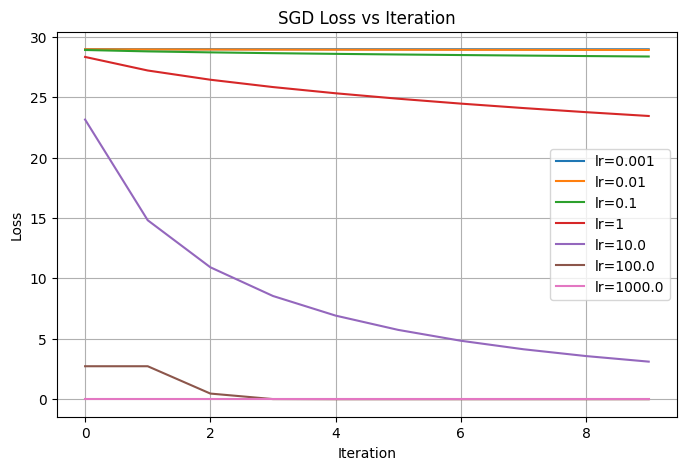

In [3]:
import torch
import matplotlib.pyplot as plt
from cs336_basics.optim.sgd import run_sgd

plt.figure(figsize=(8, 5))
weights = torch.nn.Parameter(5 * torch.randn((10, 10)))
lrs = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
for lr in lrs:
    print(f"Learning rate: {lr}")
    losses = run_sgd(
        lr=lr,
        weights=weights,
        num_iterations=10,
    )
    plt.plot(losses, label=f"lr={lr}")
    print()

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("SGD Loss vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

# Train

In [2]:
327_680_000 / 32 / 256

40000.0

In [ ]:
import numpy as np

validation_ds = np.load("data/sync/tokenized/TinyStoriesV2-GPT4/valid.npy")
print(validation_ds.shape)

(5465963,)


In [5]:
validation_ds.shape[0] / 32 / 256

667.2318115234375

In [ ]:
valid_small_ds = validation_ds[: 200 * 32 * 256]
print(valid_small_ds.shape)

(1638400,)


In [10]:
np.save("data/sync/tokenized/TinyStoriesV2-GPT4/valid_small.npy", valid_small_ds)

In [11]:
test_ds = np.load("data/sync/tokenized/TinyStoriesV2-GPT4/valid_small.npy")
assert test_ds.shape == valid_small_ds.shape, "The saved and loaded datasets do not match!"

In [ ]:
train_ds = np.load("data/sync/tokenized/TinyStoriesV2-GPT4/train.npy")
print(train_ds.shape)
train_ds.shape[0] / 32 / 256

(541235478,)


66068.78393554688

In [7]:
import wandb


wandb.init(
    project="cs336",
    entity="yanlinyc-thatcher",
    name="train-test",
    config={
        "learning_rate": 0.001,
        "batch_size": 32,
        "epochs": 10,
    },
)

wandb.log({"loss": 0.5, "accuracy": 0.8})

wandb.finish()

accuracy,▁
loss,▁
accuracy,0.8
loss,0.5


In [1]:
# Test

import torch

torch.device("cuda")

device(type='cuda')

In [ ]:
a = {"key1": 1, "key2": 2}